# SVM, Transformers, Pipelines

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mglearn

from IPython.display import display

%matplotlib inline

# Задачи до момента

1. Изберете dataset и направете data exploration
2. Опитайте да направите по-добри резултати от нас на Titanic
3. Опитайте да направите по-добри резултати от нас на Spooky Author Detection

# Support Vector Machines

SVM е особен алгоритъм, който не се обяснява добре с малко математика.

* Класификационнен алгоритъм (може да се обърне до регресия, но игнорирайте засега)
* Опитва се да намери хиперпланина, която да разделя двата класа
* Оптимизира дистанцията от хиперпланината до точките, както и margin-а между тях
* Има нещо, наречено kernel trick, което може да се справи с нелинейни разделения
* Може да се оправи с повече feature-и, отколкото данни (макар да има хлъзгави плоскости)
* Чувствителен към скалирането на данните

## Детайли

Математиката е интересна, но не е тривиална за обясняване. Ако искате да прочетете повече, тук има един хубав материал от Andrew Ng:

http://cs229.stanford.edu/notes/cs229-notes3.pdf

Ще се опитаме да създадем неформална интуиция отгоре-отгоре.

Има няколко разновидности. Ще погледнем първо линейните:

Пример за линеен SVM, намиращ хиперпланина (права в 2D):

![](http://scikit-learn.org/stable/_images/sphx_glr_plot_separating_hyperplane_0011.png)

Алгоритъма се опитва да оптимизира margin-а (разстоянието между пунктираните линии).

За класификация, може да ползвате `LinearSVC`:

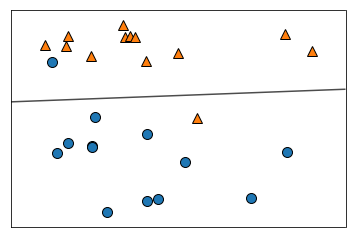

In [2]:
from sklearn.svm import LinearSVC

X, y = mglearn.datasets.make_forge()

model = LinearSVC().fit(X, y)
mglearn.plots.plot_2d_separator(model, X, fill=False, eps=0.5, alpha=.7)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y);

Има регуляризационен параметър `C`, който е обратно пропорционален на колко регуляризация искаме – ниски стойности на `C` предизвикват голяма резуляризация и обратното.

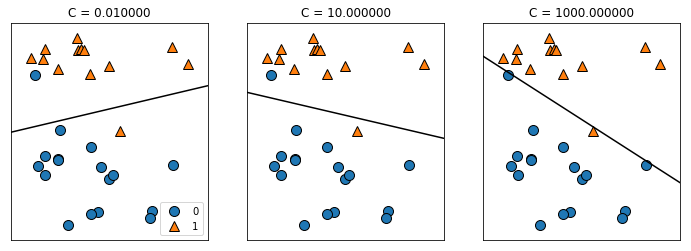

In [3]:
mglearn.plots.plot_linear_svc_regularization()

В горните диаграми се вижда, че голяма регуляризация (малко `C`) поставя акцента върху клъстерите от точки, докато ниската регуляризация (голямо `C`) се опитва да класифицира правилно всяка една точка.

## Нелинейни проблеми

Преди да видим нелинейни kernel-и, нека да си припомним ограниченията на линейните модели и как може да се заобиколят.

Да започнем със нелинеен dataset:

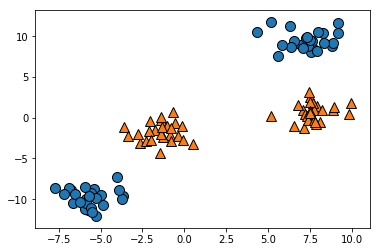

In [4]:
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=4, random_state=8)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y);

Да видим какво ще направи линеен модел:

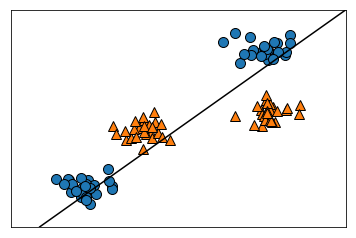

In [5]:
model = LinearSVC().fit(X, y)
mglearn.plots.plot_2d_separator(model, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y);

Как изглежда успеваемостта на train set-а?

In [6]:
model.score(X, y)

0.67000000000000004

Слабо. Да пробваме да добавим нов feature, който е квадрата на един от съществуващите. Т.е., започваме с:

In [7]:
X[:5]

array([[-1.72161036, -1.48033142],
       [-3.6573384 , -9.5482383 ],
       [ 7.0778163 ,  0.99508772],
       [-1.36579859, -0.3148625 ],
       [-2.66521206, -3.12591651]])

И добавяме $x_2^2$ като трети feature:

In [8]:
X_new = np.hstack([X, X[:, 1:] ** 2])

In [9]:
X_new[:5]

array([[ -1.72161036,  -1.48033142,   2.19138111],
       [ -3.6573384 ,  -9.5482383 ,  91.16885455],
       [  7.0778163 ,   0.99508772,   0.99019957],
       [ -1.36579859,  -0.3148625 ,   0.09913839],
       [ -2.66521206,  -3.12591651,   9.77135405]])

Нека да начертаем новите данни:

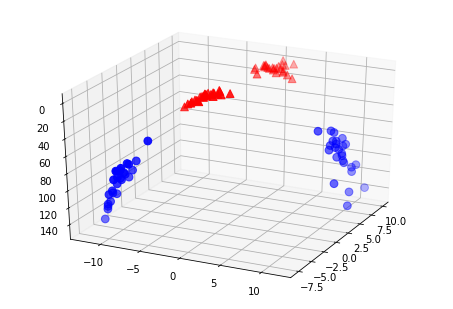

In [10]:
from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()

ax = Axes3D(figure, elev=-152, azim=-26)
mask = (y == 0)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', cmap=mglearn.cm2, s=60);

Това изглежда като разделимо с равнина. Да пробваме да я натренираме `LinearSVM`:

In [11]:
model = LinearSVC().fit(X_new, y)
model.score(X_new, y)

1.0

Явно наистина може да разделим тези точки с равнина!

Ако избухнем с малко код, може и дори да я начертаем:

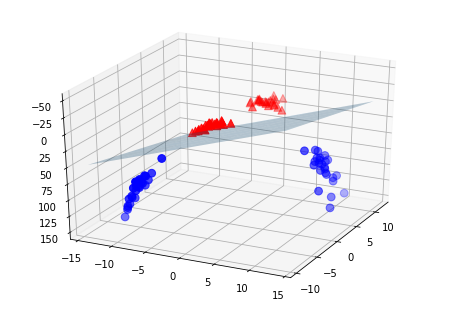

In [12]:
coef, intercept = model.coef_.ravel(), model.intercept_

figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)
XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60)
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', cmap=mglearn.cm2, s=60);

Може и да погледнем това "отгоре":

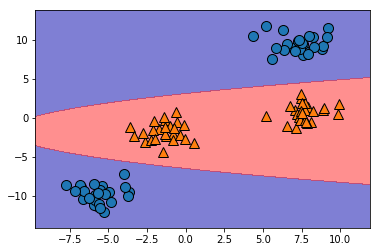

In [13]:
ZZ = YY ** 2
dec = model.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()], cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y);

## Gaussian Kernel

Накратко и доста нетчно, ако ползвате gaussian kernel, алгоритъма сам може да намери подходящи полиномни feature-и. И да класифицира правилно.

За целта ползвате `SVC` със `kernel='rbf'`, което е и стойността по подразбиране. RBF идва от Radial Basis Function.

Зад това има доста математика, в която дори няма да си помисляме да навлизаме.

In [14]:
from sklearn.svm import SVC

model = SVC().fit(X, y)
model.score(X, y)

1.0

Резултата е същия (намери се пълно разделение), без да се налага да познаваме какви полиномни feature-и ни трябват.

## Хипер-параметри

Има два интересни параметъра – `gamma` и `C`.

За да ги илюстрираме, ще разгледаме един друг синтетичен dataset.

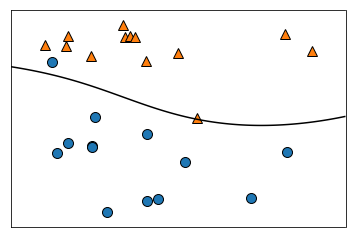

In [15]:
X, y = mglearn.tools.make_handcrafted_dataset()
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y);

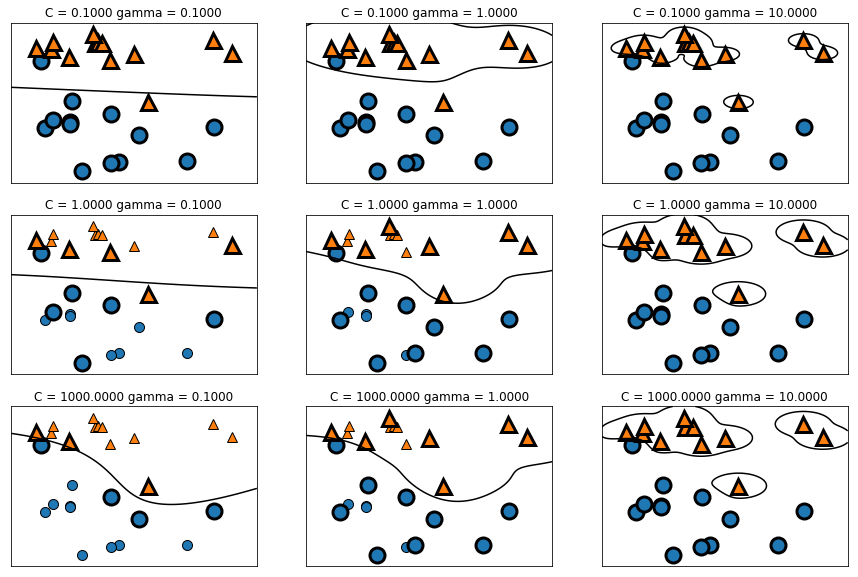

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)

Без математиката е трудно за обяснение. Най-близкото до което може да стигнем е:

* `C` е стандартния регуляризационен параметър
* `gamma` е обратно пропорционална на широчината на gaussian kernel-а (хъхъ). Висока gamma ще създава по-комплексни decision boundary-ита.

SVM са много чувствителни на мащаба на данните. Преди да го илсютрираме, нека първо разгледаме инструментите за мащабиране.

# MinMaxScaler

Този клас позволява да промените мащаба на дадени данни. Например:

In [17]:
from sklearn.preprocessing import MinMaxScaler

data = [[100], [120], [170], [250], [300]]
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data)
scaler.transform(data)

array([[ 0.  ],
       [ 0.1 ],
       [ 0.35],
       [ 0.75],
       [ 1.  ]])

Може да видите параметрите, с които той оперира:

In [18]:
print("scale: {}".format(scaler.scale_))
print("min: {}".format(scaler.min_))
print("data min: {}".format(scaler.data_min_))
print("data max: {}".format(scaler.data_max_))

scale: [ 0.005]
min: [-0.5]
data min: [ 100.]
data max: [ 300.]


Веднъж като сте `fit`-нали на едни данни, може да ползвате `transform` за следващите.

In [19]:
scaler.transform([[150], [200], [250]])

array([[ 0.25],
       [ 0.5 ],
       [ 0.75]])

Обърнете внимание, че правим един `fit` и много `transform`-и.

`MinMaxScaler` ще скалира и данни извън първоначалния range:

In [20]:
scaler.transform([[0], [400]])

array([[-0.5],
       [ 1.5]])

Има и още един метод, `fit_transform`, който прави `fit` + `transform`:

In [21]:
data = [[100, -10], [120, 5], [170, 2]]
MinMaxScaler().fit_transform(data)

array([[ 0.        ,  0.        ],
       [ 0.28571429,  1.        ],
       [ 1.        ,  0.8       ]])

`MinMaxScaler` работи върху всички колони. Ако искате да обработите само някои, има и функция:

In [22]:
from sklearn.preprocessing import minmax_scale

minmax_scale([[1], [2], [4]])

array([[ 0.        ],
       [ 0.33333333],
       [ 1.        ]])

Може директно да я ползвате и за `DataFrame`:

In [23]:
frame = pd.DataFrame({
    'name': ['Edward', 'Bella', 'Jacob'],
    'age': [17, 18, 16]
}, columns=['name', 'age'])
frame

,name,age
0,Edward,17
1,Bella,18
2,Jacob,16


In [24]:
frame[['age']] = minmax_scale(frame[['age']])
frame

,name,age
0,Edward,0.5
1,Bella,1.0
2,Jacob,0.0


# StandardScaler

Подобен механизъм, който скалира до средна стойност (mean) 0 и дисперсия (variance) 1.

In [25]:
from sklearn.preprocessing import StandardScaler

data = np.array([0.0, 1.0, 3.0, 7.0, 42.0, 100.0, 2.0]).reshape(-1, 1)
StandardScaler().fit_transform(data)

array([[-0.63940499],
       [-0.61052864],
       [-0.55277593],
       [-0.43727051],
       [ 0.5734019 ],
       [ 2.24823046],
       [-0.58165228]])

Разбира се, има и функция:

In [26]:
from sklearn.preprocessing import scale

scale([0.0, 7.0, 12.0, 80.0])

array([-0.76906108, -0.55154886, -0.39618298,  1.71679293])

Всичко до тук е част от по-голяма абстракция – трансформери (трансформатори?).

# Transformers

В scikit-learn има класове, чиято цел е да трансформират данните. Те се характеризират със `fit` и `transform` методи:

* `fit` се вика веднъж за да "настрои" трансформацията.
* `transform` може да се вика много пъти след като вече има трансформация.
* `fit_transform` прави и двете.

В някои специални случаи, клас ще има само `fit_transform`.

Може да си имплементираме собствени трансформатори:

In [27]:
from sklearn.base import TransformerMixin

class Logarithmizer(TransformerMixin):
    def transform(self, X, *_):
        return np.log(X)

    def fit(self, *_):
        return self

In [28]:
data = [0.5, 1, 2.71828182, 7.38905609, 10]
Logarithmizer().fit_transform(data)

array([-0.69314718,  0.        ,  1.        ,  2.        ,  2.30258509])

# Imputer

`Imputer` е трасформер, който попълва липсващите данни. Има три стратегии, контролирани с параметър `strategy`:

* `mean` – средно аритметично
* `median` – медиана
* `most_frequent` – мода

In [29]:
from sklearn.preprocessing import Imputer

values = np.array([1.0, 5.0, np.nan, 1.0, 2.0, np.nan]).reshape(-1, 1)
Imputer(strategy='most_frequent').fit_transform(values)

array([[ 1.],
       [ 5.],
       [ 1.],
       [ 1.],
       [ 2.],
       [ 1.]])

# Други

* `OneHotEncoder` е трансформер
* `LabelEncoder` също
* Има и `LabelBinarizer`, който е комбинация от горните две

# PolynomialFeatures

Трансформер, който дава полиномни фийчъри.

In [30]:
from sklearn.preprocessing import PolynomialFeatures

data = [[1, 2],
        [3, 4],
        [6, 2]]
PolynomialFeatures().fit_transform(data)

array([[  1.,   1.,   2.,   1.,   2.,   4.],
       [  1.,   3.,   4.,   9.,  12.,  16.],
       [  1.,   6.,   2.,  36.,  12.,   4.]])

## Аргументи

* `degrees=2` – максимална степен на полиномите
* `include_bias=True` – константен feature
* `interaction_only=False` – не включва членове, където има степен, по-голяма от първа (без $x^2$, $y^3$ или $x^2y$)

# SVM и мащабиране

Support Vector Machine-ите са чувствителни на мащабиране на feature-ите. Например:

In [31]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [32]:
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

unscaled_score = SVC().fit(X_train, y_train).score(X_test, y_test)
scaled_score = SVC().fit(X_train_scaled, y_train).score(X_test_scaled, y_test)

print("Unscaled score: {:.2f}".format(unscaled_score))
print("Scaled score:   {:.2f}".format(scaled_score))

Unscaled score: 0.63
Scaled score:   0.97


Това важи и за `LinearSVC`, Лъчо:

In [33]:
from sklearn.svm import LinearSVC

unscaled_score = LinearSVC(random_state=42).fit(X_train, y_train).score(X_test, y_test)
scaled_score   = LinearSVC(random_state=42).fit(X_train_scaled, y_train).score(X_test_scaled, y_test)

print("Unscaled score: {:.2f}".format(unscaled_score))
print("Scaled score:   {:.2f}".format(scaled_score))

Unscaled score: 0.64
Scaled score:   0.94


# Pipeline

`Pipeline`-а позволява да се наредят няколко стъпки една след друга.

In [34]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('svm', LinearSVC()),
])

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.94405594405594406

Всяка стъпка преди последната трябва да е трансформер (да има `fit` и `transform`). Последната може да е и класификатор (`fit`, `predict` и `score`).

Имената в аргументите на pipeline са полезни понякога заради други операции, които може да прилагаме. Ще разгледаме това малко по-късно.

В по-лесния случай може да ползваме `make_pipeline`.

In [35]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(StandardScaler(), LinearSVC())

pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.94405594405594406

Може да видим, че `make_pipeline` прави същото, но използва имената на класовете с малки букви:

In [36]:
pipeline

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearsvc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

# Hyperparameter searching

Вече сме видяли няколко класа, които ни помагат с търсенето:

* `GridSearchCV` – пробва всички комбинации от параметри
* `RandomizedSearchCV` – пробва няколко sample-а от всички комбинации с параметри

Те работят добре и с pipelines. Нека видим пример:

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge

boston = load_boston()
X, y = boston.data, boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [38]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('polynomials', PolynomialFeatures()),
    ('ridge', Ridge())
])

grid = {
    'polynomials__degree': [1, 2, 3],
    'ridge__alpha': [0.001, 0.01, 1, 10, 100],
}

search = GridSearchCV(pipeline, param_grid=grid, cv=5)

Обърнете внимане подаваме параметрите при pipeline – имаме името на стъпката (напр. `polynomials`), последвано от две подчертавки (`__`), след което имаме името на параметъра (`degrees`).

In [39]:
search.fit(X_train, y_train);

In [40]:
search.best_params_

{'polynomials__degree': 2, 'ridge__alpha': 10}

Може да видим всички резултати:

In [41]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_polynomials__degree,param_ridge__alpha,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.003542,0.000884,0.721694,0.772803,1,0.001,"{'polynomials__degree': 1, 'ridge__alpha': 0.001}",9,0.762387,0.766816,...,0.779522,0.761761,0.707730,0.787388,0.790342,0.759864,0.002982,0.000428,0.081399,0.012446
1,0.002146,0.000622,0.721697,0.772803,1,0.01,"{'polynomials__degree': 1, 'ridge__alpha': 0.01}",8,0.762401,0.766816,...,0.779523,0.761761,0.707723,0.787388,0.790354,0.759864,0.001008,0.000134,0.081404,0.012446
2,0.002319,0.001050,0.722038,0.772776,1,1,"{'polynomials__degree': 1, 'ridge__alpha': 1}",7,0.763916,0.766784,...,0.779563,0.761738,0.706941,0.787363,0.791627,0.759829,0.001371,0.000460,0.081928,0.012450
3,0.002809,0.001069,0.723071,0.771205,1,10,"{'polynomials__degree': 1, 'ridge__alpha': 10}",6,0.773681,0.764863,...,0.778530,0.760291,0.700024,0.785961,0.796621,0.757876,0.000990,0.000534,0.084632,0.012691
4,0.003158,0.001700,0.707722,0.742466,1,100,"{'polynomials__degree': 1, 'ridge__alpha': 100}",10,0.781262,0.730725,...,0.744228,0.731635,0.654120,0.759497,0.766063,0.727537,0.001812,0.000763,0.072169,0.015408
5,0.005680,0.002298,0.738644,0.958945,2,0.001,"{'polynomials__degree': 2, 'ridge__alpha': 0.001}",4,0.817361,0.959482,...,0.519241,0.958627,0.812608,0.962971,0.901746,0.950145,0.002325,0.000531,0.137977,0.004791
6,0.007498,0.017363,0.737568,0.958657,2,0.01,"{'polynomials__degree': 2, 'ridge__alpha': 0.01}",5,0.820835,0.958810,...,0.513348,0.958347,0.814478,0.962909,0.901075,0.949825,0.003326,0.027381,0.140881,0.004871
7,0.009758,0.005052,0.776821,0.954422,2,1,"{'polynomials__degree': 2, 'ridge__alpha': 1}",3,0.835563,0.955212,...,0.634127,0.953334,0.868589,0.957103,0.912879,0.946134,0.003945,0.002793,0.119059,0.004745
8,0.008061,0.005479,0.821038,0.942211,2,10,"{'polynomials__degree': 2, 'ridge__alpha': 10}",1,0.868418,0.943656,...,0.835014,0.935919,0.873468,0.944418,0.909443,0.935434,0.004056,0.003175,0.103397,0.006018
9,0.005448,0.002597,0.806301,0.898369,2,100,"{'polynomials__degree': 2, 'ridge__alpha': 100}",2,0.873005,0.896810,...,0.845755,0.891736,0.837275,0.901086,0.851550,0.893626,0.001647,0.000894,0.091808,0.006013


Вероятно ще е по-добре да си ги начертаем графично:

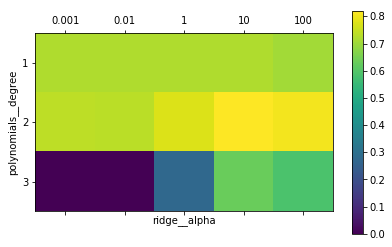

In [42]:
plt.matshow(search.cv_results_['mean_test_score'].reshape(3, -1), vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomials__degree")
plt.xticks(range(len(grid['ridge__alpha'])), grid['ridge__alpha'])
plt.yticks(range(len(grid['polynomials__degree'])), grid['polynomials__degree'])
plt.colorbar();

От графикта се вижда, че сме подбрали обхвата на параметрите добре. Ако максимума бе в ръб или ъгъл, щеше да има смисъл да погледнем други параметри.

Може да търсим и различни комбинации за даден модел – например да ползваме едни параметри при `kernel=rbf` и други при `kernel=linear`.

In [43]:
from sklearn.datasets import load_iris

iris = load_iris()

grid = [
    {'kernel': ['rbf'],
     'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
     'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'kernel': ['linear'],
     'C': [0.001, 0.01, 0.1, 1, 10, 100]}
]

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
search = GridSearchCV(SVC(), grid, cv=5)
search.fit(X_train, y_train)

print(search.best_params_)
print(search.best_score_)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.973214285714


Може дори да направим `GridSearch` в който заменяме стъпките от pipeline-а – например, може да търсим няколко комбинации от класификатори и scaler-и.

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler

pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

grid = [
    {
        'classifier': [SVC()],
        'preprocessing': [RobustScaler(), StandardScaler(), MinMaxScaler()],
        'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    {
        'classifier': [RandomForestClassifier(n_estimators=100)],
        'preprocessing': [None],
        'classifier__max_features': [1, 2, 3]
    }
]

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
search = GridSearchCV(pipe, grid, cv=5)
search.fit(X_train, y_train)

print("Best params:\n{}\n".format(search.best_params_))
print("Best cross-validation score: {:.2f}".format(search.best_score_))

Best params:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best cross-validation score: 0.99


Нека видим още един интересен проблем. Ще се пробваме със същия dataset, но този път с cross validation.

In [45]:
from sklearn.model_selection import cross_val_score

cancer = load_breast_cancer()
X, y = scale(cancer.data), cancer.target

score = cross_val_score(LinearSVC(), X, y, cv=3)
print(score)
print(score.mean())

[ 0.95263158  0.96842105  0.96825397]
0.963102199944


Какъв е проблема в горния код?

Данните се мащабират преди train-test split-а, направен от крос валидацията. По този начин изтича информация от тестовия сет към тренирането. Това няма да се случи с реални данни, обаче – те ще идват с мащаб, който алгоритъма няма да знае. По-реалистично е да мащабираме само тестовите данни и да оставим възможността тестовия сет да излиза настрани.

Това може да се случи като дадем `pipeline`-а на `cross_val_score` – така той ще прави отделно мащабиране за всяко разделение, което ще е по-реален индикатор на точността.

In [46]:
X, y = cancer.data, cancer.target
pipeline = make_pipeline(StandardScaler(), LinearSVC())
score = cross_val_score(pipeline, X, y, cv=3)
print(score)
print(score.mean())

[ 0.94736842  0.96842105  0.96825397]
0.961347813979


Може да видим, че с първия fold имаме по-лош (и по-реалистичен) резултат.

Ето визуализация на грешния подход:

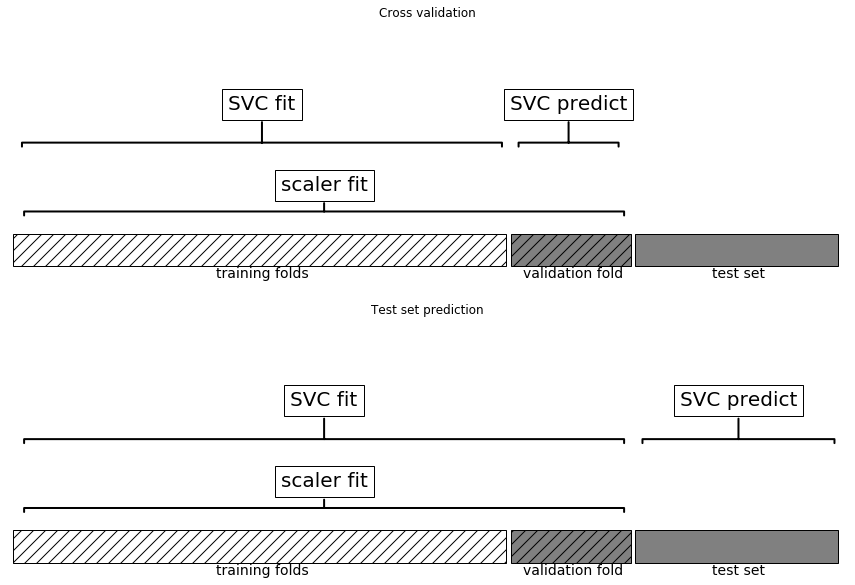

In [47]:
mglearn.plots.plot_improper_processing()

Ето как нещата трябва да изглеждат наистина:

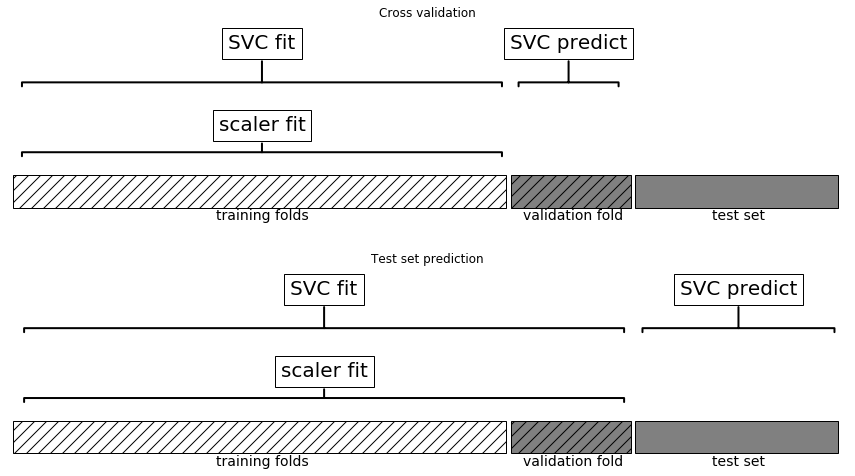

In [48]:
mglearn.plots.plot_proper_processing()

# FeatureUnion

Това е интересен клас, който помага за preprocessing-а на данни. Нека видим банален пример – искаме да извлечем едновременно полиномни feature-и и скалиран feature.

In [49]:
data = np.array([1.0, 5.0, 2.0, 7.0]).reshape(-1, 1)

In [50]:
PolynomialFeatures().fit_transform(data)

array([[  1.,   1.,   1.],
       [  1.,   5.,  25.],
       [  1.,   2.,   4.],
       [  1.,   7.,  49.]])

In [51]:
StandardScaler().fit_transform(data)

array([[-1.15311332],
       [ 0.52414242],
       [-0.73379939],
       [ 1.36277029]])

Бихме могли просто да конкатенираме двете матрици:

In [52]:
np.concatenate([
    PolynomialFeatures().fit_transform(data),
    StandardScaler().fit_transform(data)
], axis=1)

array([[  1.        ,   1.        ,   1.        ,  -1.15311332],
       [  1.        ,   5.        ,  25.        ,   0.52414242],
       [  1.        ,   2.        ,   4.        ,  -0.73379939],
       [  1.        ,   7.        ,  49.        ,   1.36277029]])

Има по-добър начин:

In [53]:
from sklearn.pipeline import FeatureUnion

union = FeatureUnion([
    ('polynomials', PolynomialFeatures()),
    ('scaled', StandardScaler()),
])
union.fit_transform(data)

array([[  1.        ,   1.        ,   1.        ,  -1.15311332],
       [  1.        ,   5.        ,  25.        ,   0.52414242],
       [  1.        ,   2.        ,   4.        ,  -0.73379939],
       [  1.        ,   7.        ,  49.        ,   1.36277029]])

Разбира се, аргументите на `FeatureUnion` могат да бъдат и `Pipeline` обекти. Например, бихме могли да прекараме стойностите `MinMaxScaler` преди да ги дадем на `PolynomialFeatures`:

In [54]:
union = FeatureUnion([
    ('polynomials', Pipeline([
        ('minmax', MinMaxScaler()),
        ('polynomials', PolynomialFeatures())
    ])),
    ('scaled', StandardScaler()),
])
union.fit_transform(data)

array([[ 1.        ,  0.        ,  0.        , -1.15311332],
       [ 1.        ,  0.66666667,  0.44444444,  0.52414242],
       [ 1.        ,  0.16666667,  0.02777778, -0.73379939],
       [ 1.        ,  1.        ,  1.        ,  1.36277029]])

С тези механизми може да си дефинираме нагледно preprocessing-а на данни.

Нека започнем с един познат dataset:

In [55]:
titanic = pd.read_csv('data/titanic/train.csv')
titanic.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Ще си дефинираме трансформер, който взема само една колона:

In [56]:
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[[self.key]]

Да видим дали работи:

In [57]:
ItemSelector('Age').fit_transform(titanic).head(10)

,Age
0,22.0
1,38.0
2,26.0
3,35.0
4,35.0
5,NaN
6,54.0
7,2.0
8,27.0
9,14.0


Пушка!

Сега може да построим нещо с `FeatureUnion`:

In [58]:
union = FeatureUnion([
    ('age', Pipeline([
        ('select', ItemSelector('Age')),
        ('imputer', Imputer(strategy='mean')),
        ('scaler', StandardScaler()),
    ]))
])

union.fit_transform(titanic)[:10]

array([[-0.5924806 ],
       [ 0.63878901],
       [-0.2846632 ],
       [ 0.40792596],
       [ 0.40792596],
       [ 0.        ],
       [ 1.87005862],
       [-2.13156761],
       [-0.20770885],
       [-1.20811541]])

Чудесно!

Нека сега пробваме друго:

In [59]:
from sklearn.preprocessing import LabelBinarizer

union = FeatureUnion([
    ('gender', Pipeline([
        ('select', ItemSelector('Sex')),
        ('imputer', Imputer(strategy='most_frequent')),
        ('encoder', LabelBinarizer()),
    ]))
])

try:
    union.fit_transform(titanic)
except Exception as e:
    print(e)

could not convert string to float: 'male'


Не стана.

И `Imputer` и `LabelBinarizer` не работят добре в Pipeline. Нека си направим собствени.

In [60]:
class LabelBinarizerPipelineFriendly(LabelBinarizer):
    def fit(self, X, y=None):
        super().fit(X)

    def transform(self, X, y=None):
        return super().transform(X)

    def fit_transform(self, X, y=None):
        return super().fit(X).transform(X)

In [61]:
class StringImputer(TransformerMixin):
    def fit(self, X, *_):
        self.modes = X.mode().iloc[0]
        return self
        
    def transform(self, X, y=None):
        return X.fillna(self.modes)

In [62]:
union = FeatureUnion([
    ('gender', Pipeline([
        ('select', ItemSelector('Sex')),
        ('imputer', StringImputer()),
        ('encoder', LabelBinarizerPipelineFriendly()),
    ]))
])

union.fit_transform(titanic)[:5]

array([[1],
       [0],
       [0],
       [0],
       [1]])

И сега всичко наведнъж:

In [63]:
model = Pipeline([
    ('union', FeatureUnion([
        ('age', Pipeline([
            ('select', ItemSelector('Age')),
            ('imputer', Imputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ])),
        ('gender', Pipeline([
            ('select', ItemSelector('Sex')),
            ('imputer', StringImputer()),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('embarked', Pipeline([
            ('select', ItemSelector('Embarked')),
            ('imputer', StringImputer()),
            ('encoder', LabelBinarizerPipelineFriendly()),
        ])),
        ('sibsp', Pipeline([
            ('select', ItemSelector('SibSp')),
            ('scaler', StandardScaler()),
        ])),
        ('parch', Pipeline([
            ('select', ItemSelector('Parch')),
            ('scaler', StandardScaler()),
        ])),
    ])),
    ('svc', SVC())
])

scores = cross_val_score(model, titanic, titanic['Survived'])
print(scores)
print(scores.mean())

[ 0.81144781  0.83164983  0.82491582]
0.822671156004


# Въпроси